* Import the necessary libraries for computations and plotting

In [2]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd  
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

* Construct a class for the boundary value problem (BVP).

In [3]:
class BVP(object): 
    def __init__(self, f, g=0, a=0, M=10, N=10):
        # right hand side (function)
        self.f = f
        # boundary conditions (function)
        self.a = a
        self.g = g
        # Numbr of subdivision along x-axis (total number of points, including boundaries)
        self.M = M
        # Numbr of subdivision along y-axis (total number of points, including boundaries)
        self.N = N

In [4]:
def grid(bvp): 
        
    x = np.linspace(0, 1.0, bvp.M)
    y = np.linspace(0, 1.0, bvp.N)
    
    # these ones are valid only for this case
    # in general the radius of the smallest inscribed
    # circle should be taken
    h=x[1]-x[0] # x typical space-step
    k=y[1]-y[0] # y typical space-step
    
    # full coorindate array of INTERNAL points
    shape = [len(x[1:-1]), len(y[1:-1])]
    x, y = np.meshgrid(x[1:-1], y[1:-1])

    # reshaping so that I have columnwise vectors
    # with all the x and y coordinates. In practice, THIS passage already
    # re-order the array in a vector that follows the numbering explained
    # in the figure above
    x, y = x.flatten(), y.flatten()
    
    # array with coordinates
    coord = np.zeros((x.size,2))
    coord[:,0]=x
    coord[:,1]=y
    
    return h, k, coord, shape

* Implement the solver. 

In [5]:
def solve_bvp(bvp):
    # Retrieving the mesh sizes in the two dimensions,
    # the coordinates of the points (ordered) and the
    # shape of the array of INTERNAL points
    h, k, coord, shape = grid(bvp)
    # Initialization of the algebraic system
    A=np.zeros((coord[:,1].size,coord[:,1].size));
    b=np.zeros(len(coord[:,1]));
    # Addition of the forcing term
    b += -bvp.f(bvp.a, k/h, coord[:,0],coord[:,1])
    # number of internal points along x in one row
    # needed to locate the points around a chosen point
    M_int = shape[0]
    
    # tolerance in checking a node is on the boundary
    tol = 1e-10
    
    # Filling the matrix row by row (not efficient, done for educational purposes)
    for i, (x,y) in enumerate(zip(coord[:,0], coord[:,1])):
        # N.B.: the command enumerate(zip(coord[:,0], coord[:,1])) just bind together
        # the two columns of coord (the x and y coordinates of my internal points) so that
        # they can be used in the cycle for. In this way, when the iterator "i" is a certain number
        # the variables "x" and "y" contain the respective coordinates of the correspondin points
        # in the i-th row of the array "coord"
        
        A[i,i] = 2*bvp.a/h**2 + 2/h**2
        
        # check if the stencil touches the left boundary
        if (math.isclose(x-h,0., abs_tol = tol)):
            
            A[i,i+1] = -bvp.a/h**2
            b[i] += bvp.a*bvp.g(x-h,y)/h**2 
            b[i] += bvp.g(x-h,y-k)/h**2
            
            # check it the stencil touches also the upper boundary
            if (math.isclose(y+k,1., abs_tol = tol)):                
                b[i] += bvp.g(x+h,y+k)/h**2
            else:
                A[i,i+M_int+1] = -1/h**2
        # check if the stencil touches the right boundary
        elif (math.isclose(x+h,1., abs_tol = tol)):
            
            A[i,i-1] = -bvp.a/h**2
            b[i] += bvp.a*bvp.g(x+h,y)/h**2 
            b[i] += bvp.g(x+h,y+k)/h**2
                
            # check if the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x-h,y-k)*1/(h**2)
            else:
                A[i,i-M_int-1] = -1/h**2
                
        else:
            # the stencil touches neither right or left boundary
            A[i,i+1] = -bvp.a/h**2
            A[i,i-1] = -bvp.a/h**2
            
            # check if the stencil touches the upper boundary
            if (math.isclose(y+k,1., abs_tol = tol)):
                b[i] += bvp.g(x+h,y+k)/h**2
            else:
                A[i,i+M_int+1] = -1/h**2
            #check if the stencil touches the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x-h,y-k)/h**2
            else:
                A[i,i-M_int-1] = -1/h**2
    
    # Plot the structure of the assembled array
    
    # Solve the linear system
    U = np.linalg.solve(A, b)
    # Just flip the vector
    U = np.reshape(U,-1)
    return U, A, coord

## Run a numerical test



In [6]:
def u_sol_1(x,y):
    return x*(1-x)*y*(1-y)

def f_1(a,r, x, y):
    return -(a+1)*2*y*(1-y) + 2*r*(2*y -1)*(2*x-1)-2*r**2 * x*(1-x)

def u_sol_2(x,y):
    return x**2 * y**2

def f_2(a, r, x, y):
    return (1+a)*2*y**2 + 8*r*x*y + 2*r**2*x**2

def u_sol_3(x,y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f_3(a,r,x, y):
    return -(1+a)*np.pi**2*np.sin(np.pi*y)*np.sin(np.pi*x) + 2*r*np.pi**2 *np.cos(np.pi*y) *np.cos(np.pi*x) - r**2 * np.pi**2 * np.sin(np.pi*x) *np.sin(np.pi*y)

#Boundary conditions
def g(x,y):
    return 0
def f(a,r,x,y):
    return x

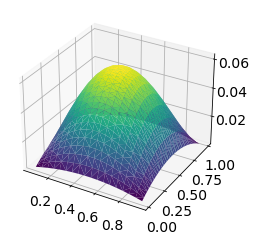

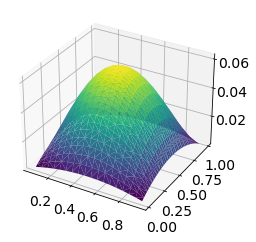

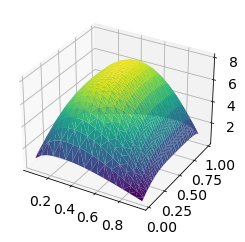

8.154245036913477e-05

In [7]:
M = 20
N = int(np.ceil(np.sqrt(2))*M)
a = 1
ex1 = BVP(f_1,u_sol_1,a,M,N)
# Solution of the problem

U, A, coord = solve_bvp(ex1)
# Plot of the solution
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U, cmap='viridis', edgecolor='none');
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u_sol_1(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U - u_sol_1(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

np.max(np.abs(U - u_sol_1(coord[:,0], coord[:,1])))

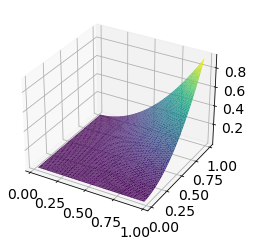

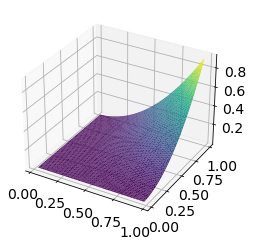

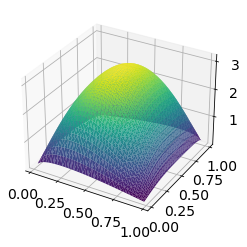

3.178503165526814e-05

In [8]:
M = 40
N = int(np.ceil(np.pi/2*40))
a = 1
ex1 = BVP(f_2,u_sol_2, 1,M,N)
# Solution of the problem
U, A, coord = solve_bvp(ex1)
# Plot of the solution
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U,
                cmap='viridis', edgecolor='none');
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u_sol_2(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U - u_sol_2(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

np.max(np.abs(U - u_sol_2(coord[:,0], coord[:,1])))

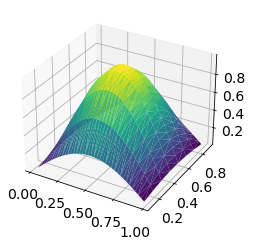

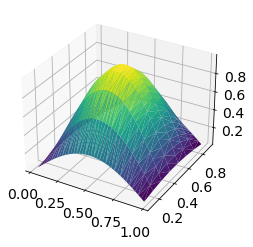

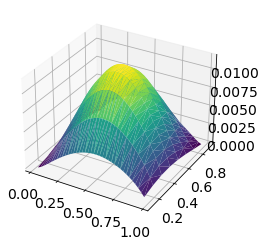

0.01168897931411128

In [9]:
M = 40
N = 10
a = 1
ex1 = BVP(f_3,u_sol_3,a,M,N)
# Solution of the problem
U, A, coord = solve_bvp(ex1)
# Plot of the solution
plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U, cmap='viridis', edgecolor='none');
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u_sol_3(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U - u_sol_3(coord[:,0], coord[:,1]),cmap='viridis', edgecolor='none')
plt.show()
np.max(np.abs(U - u_sol_3(coord[:,0], coord[:,1])))

Notice that the solution on the boundary is not plotted here. 

In [10]:
# Function operating a convergence study
def convergence(bvp, u_exact, solver=solve_bvp): 
    P = 4
    Hconv = np.zeros(P)
    Emax = np.zeros(P)
    M = np.copy(bvp.M)
    N = np.copy(bvp.N)
    for p in range(P):
        bvp1 = BVP(bvp.f, bvp.g, bvp.a, M,N)
        U, A, coord = solver(bvp1)
        Emax[p] = np.max(np.abs(u_exact(coord[:,0],coord[:,1])- U))
        Hconv[p] = coord[1,0]-coord[0,0]
        M = 2*M
        N = 2*N
    orderMax = np.polyfit(np.log(Hconv),np.log(Emax),1)[0]
    return Hconv, Emax, orderMax

In [11]:
# Plot of the convergence plot
M = 16
N = 8
a = 1
ex1 = BVP(f_1, u_sol_1, a, M, N)
H, EM, pM = convergence(ex1, u_sol_1, solve_bvp)
Rate=np.zeros(np.size(EM))
Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.5f}'.format
df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 
df

,h,Error,Rate
0,0.06667,0.00097,0.00000
1,0.03226,0.00023,1.99835
2,0.01587,0.00005,2.00594
3,0.00787,0.00001,2.00436


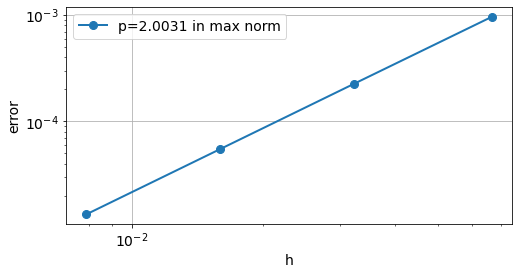

In [12]:
plt.figure()
plt.loglog(H,EM,'o-', label='p={:.4f} in max norm'.format(pM))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

In [101]:
def l(x):
    return 1/2*(np.cos(np.pi*x) + 1)

def l_inv(y):
    return 1/np.pi*np.arccos(2*y-1)

def u_where(x,y,l,u_sol):
    return np.where(l(x) >= y, u_sol(x,y),0)

def u_sol_4(x,y):
    return np.cos(np.pi*x) * np.sin(np.pi*y)

def f_4(a, r, x, y):
    return - 2*np.pi**2*np.cos(np.pi*x)*np.sin(np.pi*y)


In [102]:
def solve_bvp_fat_bound(bvp):
    # Retrieving the mesh sizes in the two dimensions,
    # the coordinates of the points (ordered) and the
    # shape of the array of INTERNAL points
    h, k, coord, shape = grid(bvp)
    
    # Initialization of the algebraic system
    A=np.zeros((coord[:,1].size,coord[:,1].size));
    b=np.zeros(len(coord[:,1]));
    
    # Addition of the forcing term
    b += -bvp.f(0, k/h, coord[:,0],coord[:,1])
    
    # number of internal points along x in one row
    # needed to locate the points around a chosen point
    M_int = shape[0]
    
    # tolerance in checking a node is on the boundary
    tol = 1e-10
    
    # Filling the matrix row by row (not efficient, done for educational purposes)
    for i, (x,y) in enumerate(zip(coord[:,0], coord[:,1])):
        
        # N.B.: the command enumerate(zip(coord[:,0], coord[:,1])) just bind together
        # the two columns of coord (the x and y coordinates of my internal points) so that
        # they can be used in the cycle for. In this way, when the iterator "i" is a certain number
        # the variables "x" and "y" contain the respective coordinates of the correspondin points
        # in the i-th row of the array "coord"
        
        if(l(x) < y): 
            #it test that allows for irregular grid, 
            # sets the solution outside of the grid automatically equal to zero
            A[i,i] = 1 
            b[i] = 0
            continue
    
        A[i,i] = 2./h**2+2/k**2
        
        # check if the stencil touches the left boundary
        if (math.isclose(x-h,0, abs_tol = tol)):
            
            A[i,i+1] = -1.0/h**2
            b[i] += bvp.g(x-h,y)/h**2
            
            # check it the stencil breaches the upper boundary
            if (l(x) < y+k):                
                b[i] += bvp.g(x,y+k)/k**2
            else:
                A[i,i+M_int] = -1.0/k**2
                
            # check it the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):                
                b[i] += bvp.g(x,y-k)/k**2   
            else:
                A[i,i-M_int] = -1.0/k**2
        
        # check if the stencil breaches the right boundary
        elif (l(x+h) < y):
            
            A[i,i-1] = -1.0/h**2
            b[i] += bvp.g(x+h,y)/h**2
                
            
            # check if the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x,y-k)/k**2
            else:
                A[i,i-M_int] = -1.0/k**2
                
            # check if the stencil breaches the upper boundary
            if (l(x) < y+k ):
                b[i] += bvp.g(x,y+k)/k**2
            else:
                A[i,i+M_int] = -1.0/k**2
                
        else:
            # the stencil can only touch the upper or lower boundary, but not the left and right
            
            A[i,i+1] = -1.0/h**2
            A[i,i-1] = -1.0/h**2
            
            # check if the stencil breaches the upper boundary
            if (l(x) < y + k):
                b[i] += bvp.g(x,y+k)/k**2
            else:
                A[i,i+M_int] = -1.0/k**2
            #check if the stencil touches the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x,y-k)/k**2
            else:
                A[i,i-M_int] = -1.0/k**2
    # Plot the structure of the assembled array            
    # Solve the linear system
    U = np.linalg.solve(A, b)
    # Just flip the vector
    U = np.reshape(U,-1)

    return U, A, coord

0.058823529411764705


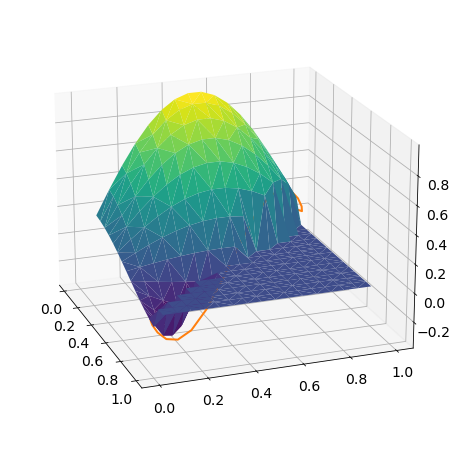

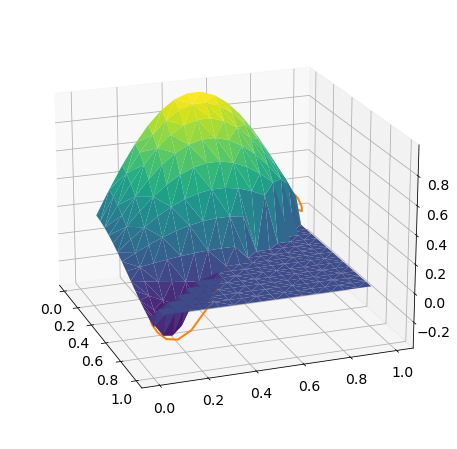

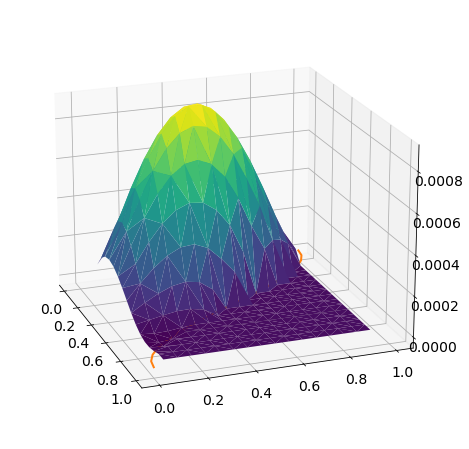

0.0009062483338115879


In [112]:
M = N = 2*10 -2
exp2 = BVP(f_4, u_sol_4, 0, M, N)
U, A, coord = solve_bvp_fat_bound(exp2)
print(coord[1,0] - coord[0,0])
x = np.linspace(0,1, M)

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U ,cmap='viridis')
ax.view_init(20, -20)
ax.plot(x, l(x), u_sol_4(x, l(x)))
plt.show()

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u_where(coord[:,0],coord[:,1],l,u_sol_4),cmap='viridis', edgecolor='none')
ax.view_init(20, -20)
ax.plot(x, l(x), u_sol_4(x, l(x)))
plt.show()

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], (U - u_where(coord[:,0],coord[:,1],l,u_sol_4)) ,cmap='viridis')
ax.view_init(20, -20)
ax.plot(x, l(x))
plt.show()

print(np.max(abs(U - u_where(coord[:,0],coord[:,1],l,u_sol_4))))


In [106]:
# Function operating a convergence study
def convergence2(bvp, u_exact, solver = solve_bvp_fat_bound): 
    P = 4
    Hconv = np.zeros(P)
    Emax = np.zeros(P)
    M = np.copy(bvp.M)
    N = np.copy(bvp.N)
    for p in range(P):
        bvp1 = BVP(bvp.f, bvp.g, bvp.a, M,N)
        U, A, coord = solver(bvp1)
        Emax[p] = np.max(np.abs(U - u_where(coord[:,0],coord[:,1], l, u_exact)))
        Hconv[p] = coord[1,0]-coord[0,0]
        M = 2*M -2
        N = 2*N -2
    orderMax = np.polyfit(np.log(Hconv),np.log(Emax),1)[0]
    return Hconv, Emax, orderMax

In [120]:
# Plot of the convergence plot
M = N = 11
a = 0
ex1 = BVP(f_4, u_sol_4, 0, M, N)
H, EM, pM = convergence2(ex1, u_sol_4, solve_bvp_fat_bound)
Rate=np.zeros(np.size(EM))
Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.5f}'.format
df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 
df

,h,Error,Rate
0,0.10000,0.00268,0.00000
1,0.05263,0.00073,2.02903
2,0.02703,0.00019,2.01492
3,0.01370,0.00005,2.00800


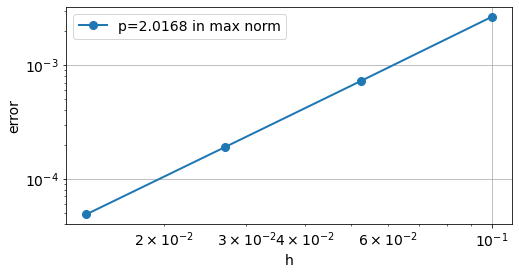

In [121]:
plt.figure()
plt.loglog(H,EM,'o-', label='p={:.4f} in max norm'.format(pM))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

In [122]:
def solve_bvp_change_disc(bvp):
    # Retrieving the mesh sizes in the two dimensions,
    # the coordinates of the points (ordered) and the
    # shape of the array of INTERNAL points
    h, k, coord, shape = grid(bvp)
    
    # Initialization of the algebraic system
    A=np.zeros((coord[:,1].size,coord[:,1].size));
    b=np.zeros(len(coord[:,1]));
    
    # Addition of the forcing term
    b += -bvp.f(0, k/h, coord[:,0],coord[:,1])
    
    # number of internal points along x in one row
    # needed to locate the points around a chosen point
    M_int = shape[0]
    
    # tolerance in checking a node is on the boundary
    tol = 1e-10
    
    # Filling the matrix row by row (not efficient, done for educational purposes)
    for i, (x,y) in enumerate(zip(coord[:,0], coord[:,1])):
        
        # N.B.: the command enumerate(zip(coord[:,0], coord[:,1])) just bind together
        # the two columns of coord (the x and y coordinates of my internal points) so that
        # they can be used in the cycle for. In this way, when the iterator "i" is a certain number
        # the variables "x" and "y" contain the respective coordinates of the correspondin points
        # in the i-th row of the array "coord"
        
        eta_y = 1
        eta_x = 1
        if(l(x) < y): 
            #it test that allows for irregular grid, 
            # sets the solution outside of the grid automatically equal to zero
            A[i,i] = 1 
            b[i] = 0
            continue
        
        # check if the stencil touches the left boundary
        if (math.isclose(x-h,0, abs_tol = tol)):
            A[i,i+1] = -2/(h**2* eta_x *(1 + eta_x))
            b[i] += bvp.g(x-h,y)*2/(h**2 * (1 + eta_x))
            # check it the stencil breaches the upper boundary
            if (l(x) < y+k and abs(l(x) - y) > 1e-14):
                eta_y = (l(x)-y)/k                
                b[i] += bvp.g(x,l(x))*2/(k**2 *eta_y * (1+eta_y))
            else:
                A[i,i+M_int] = -2/(k**2 * eta_y * (1+eta_y))

            # check it the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):                
                b[i] += bvp.g(x,y-k)*2/(k**2 * (1+eta_y))
            else:
                A[i,i-M_int] = -2/(k**2 * (1+eta_y))
    
        # check if the stencil breaches the right boundary
        elif (l(x+h) < y and abs(l_inv(y) - x ) > 1e-14):
            eta_x = (l_inv(y)-x)/h
            A[i,i-1] = -2/(h**2 *(1+eta_x))
            b[i] += bvp.g(l_inv(y),y) * 2/(h**2 * eta_x *(1+eta_x))  
                
            # check if the stencil breaches the upper boundary
            if (l(x) < y+k and abs(l(x) - y) > 1e-14):
                eta_y = (l(x)-y)/k                
                b[i] += bvp.g(x,l(x)) * 2/(k**2 *eta_y * (1+eta_y))
            else:
                A[i,i+M_int] = -2/(k**2 * eta_y * (1+eta_y))
            # check if the stencil touches also the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x,y-k)*2/(k**2 * (1+eta_y))    
            else:
                A[i,i-M_int] = -2/(k**2 * (1+eta_y))    
        else:
            # the stencil can only touch the upper or lower boundary, but not the left and right
            
            A[i,i+1] = -2/(h**2 * eta_x *(1+eta_x))
            A[i,i-1] = -2/(h**2 * (1+eta_x))
            
            # check if the stencil breaches the upper boundary
            if (l(x) < y+k and abs(l(x) - y) > 1e-14):
                eta_y = (l(x)-y)/k                
                b[i] += bvp.g(x,l(x)) * 2/(k**2 * eta_y * (1+eta_y))
            else:
                A[i,i+M_int] = -2/(k**2 * eta_y * (1+eta_y))
            
            #check if the stencil touches the lower boundary
            if (math.isclose(y-k,0., abs_tol = tol)):
                b[i] += bvp.g(x,y-k) * 2/(k**2 * eta_y * (1+eta_y))
            else:
                A[i,i-M_int] = -2/(k**2 *(1+eta_y))    
        
        if(math.isclose(eta_y,0, abs_tol = tol) or math.isclose(eta_y,0, abs_tol = tol)):
            print(eta_y, eta_x, x, l_inv(y), y, l(x))
        A[i,i] = 2./(h**2*eta_x) + 2./(k**2*eta_y)

    # Plot the structure of the assembled array            
    # Solve the linear system
    U = np.linalg.solve(A, b)
    # Just flip the vector
    U = np.reshape(U,-1)

    return U, A, coord

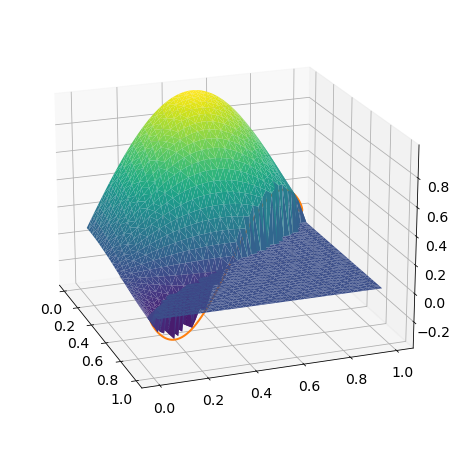

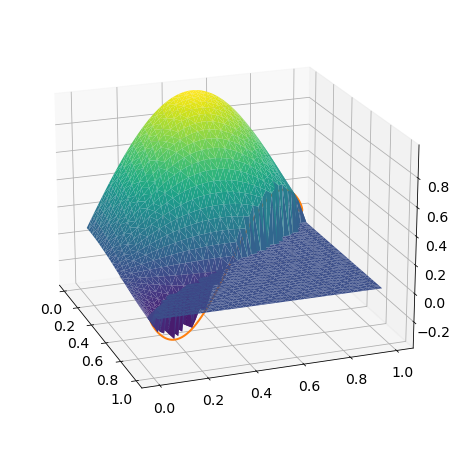

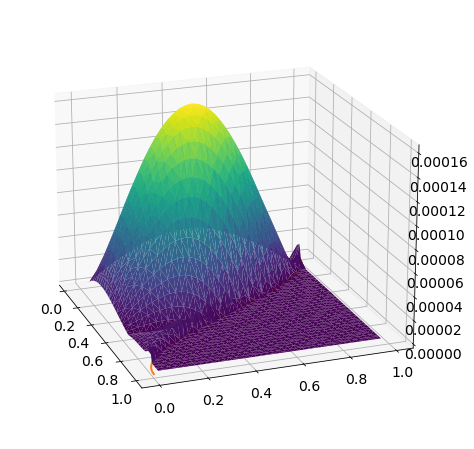

0.00016339609389859344


In [128]:
M = N = 40
exp4 = BVP(f_4, u_sol_4, 0, M,N)
U, A, coord = solve_bvp_change_disc(exp4)

x = np.linspace(0,1, 100)

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], U ,cmap='viridis')
ax.view_init(20, -20)
ax.plot(x, l(x), u_sol_4(x, l(x)))
plt.show()

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], u_where(coord[:,0],coord[:,1],l,u_sol_4),cmap='viridis', edgecolor='none')
ax.view_init(20, -20)
ax.plot(x, l(x), u_sol_4(x, l(x)))
plt.show()

plt.figure(figsize= (8,8))
ax = plt.axes(projection='3d')
ax.plot_trisurf(coord[:,0], coord[:,1], abs(U - u_where(coord[:,0],coord[:,1],l,u_sol_4)) ,cmap='viridis')
ax.view_init(20, -20)
ax.plot(x, l(x))
plt.show()

print(np.max(abs(U - u_where(coord[:,0],coord[:,1],l,u_sol_4))))


In [129]:
# Plot of the convergence plot
M = N = 12
a = 0
ex5 = BVP(f_4, u_sol_4, 0, M, N)
H, EM, pM = convergence2(ex5, u_sol_4, solve_bvp_change_disc)
Rate=np.zeros(np.size(EM))
Rate[1:]=np.log10(EM[1:]/EM[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.5f}'.format
df = pd.DataFrame(data={'h': H, 'Error': EM ,'Rate':Rate}) 
df

,h,Error,Rate
0,0.09091,0.00187,0.00000
1,0.04762,0.00055,1.90667
2,0.02439,0.00015,1.95402
3,0.01235,0.00004,1.97392


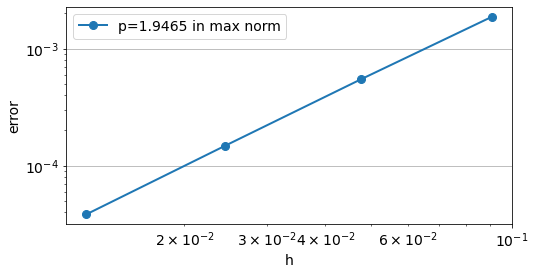

In [130]:
plt.figure()
plt.loglog(H,EM,'o-', label='p={:.4f} in max norm'.format(pM))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();